In [1]:
from dotenv import load_dotenv
load_dotenv()

True

# Part 1: Async and Parallelism

Initializing and introducing nodes

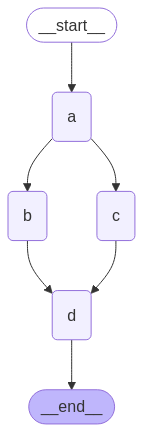

In [ ]:
import operator
from typing import Annotated, TypedDict, Any
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    state: Annotated[list, operator.add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I am A"))
builder.add_node("b", ReturnNodeValue("I am B"))
builder.add_node("c", ReturnNodeValue("I am C"))
builder.add_node("d", ReturnNodeValue("I am D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")

# To będzie działać, ale trzeba pamiętać, że będą czekały na siebie
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Dla B i C jest A -> dopiero dla D pojawi sie A,B,C
graph.invoke({"state": []})

Adding I am A to []
Adding I am B to ['I am A']
Adding I am C to ['I am A']
Adding I am D to ['I am A', 'I am B', 'I am C']


{'state': ['I am A', 'I am B', 'I am C', 'I am D']}

# Part 2: Paralell LLM nodes processing 

In [4]:
from langchain_openai import ChatOpenAI
import os


llm = ChatOpenAI(
    api_key=os.environ["OPENAI_API_KEY"],
    model="gpt-4o-mini", 
    temperature=0
)

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

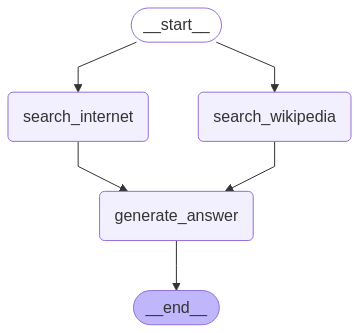

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state):

    """ Retrieve docs from web search """

    print("... Searching internet using Tavily ... \n")
    
    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    print("... Searching through Wikipedia ... \n")

    # Search
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, context=context)

    # Answer
    answer = llm.invoke(
        [SystemMessage(content=answer_instructions)] 
        + 
        [HumanMessage(content="Answer the question.")]
    )

    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_internet",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_internet")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_internet", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
result = graph.invoke({"question": "What is a business potential of LLM-based multi-agent systems in banking? Suggest the most interesting business cases"})
#result = graph.invoke({"question": "Give me ranking of best gaming laptops. Create table with pros and cons, price and official reviews"})
#result = graph.invoke({"question": "What is the current state of floods in Poland?"})
result['answer'].content

... Searching internet using Tavily ... 

... Searching through Wikipedia ... 



'The business potential of LLM-based multi-agent systems in banking is significant, as these systems can enhance various operational aspects, improve customer interactions, and optimize decision-making processes. Here are some interesting business cases that illustrate this potential:\n\n1. **Personalized Customer Service**: LLM-based agents can provide real-time, personalized interactions with customers. For instance, banks can deploy chatbots that understand customer queries and provide tailored responses, improving customer satisfaction and reducing the workload on human agents.\n\n2. **Credit Portfolio Monitoring**: As demonstrated by South State Bank, LLM agents can autonomously monitor and analyze credit portfolios. They can research and update metrics, helping banks manage risk more effectively and make informed lending decisions.\n\n3. **Branch Location Analysis**: LLM agents can analyze data, such as cell phone usage patterns, to identify optimal locations for new bank branche

# Part 3: MapReduce

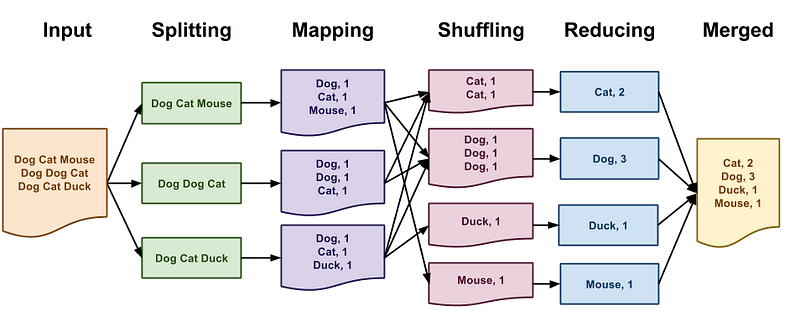

1. We do not know the amount of threads we should use
2. We need to group results

We are going to create startups ideas, process them in parallel and choose the best one

In [7]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a few, maximum 5, subjects related to the topic: {topic}."""
startup_prompt = """Create startup idea for {subject}"""
best_startup_prompt = """
Below there are a few subjects in {topic}. 
Choose the best one for unicorn startup. 
Return ID of the best one, starting from 0 as the best one. Ideas: \n\n  {ideas}"""

llm = ChatOpenAI(
    api_key=os.environ["OPENAI_API_KEY"], 
    model="o1"
) 

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.constants import Send

class Subjects(BaseModel):
    subjects: list[str]

class Beststartup(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    startups: Annotated[list, operator.add]
    best_selected_startup: str
    
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = llm.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

# Generuj do momentu aż będzie miało to sens -> podobne do zrównolegnienia
def continue_to_startups(state: OverallState):
    return [Send("generate startups", {"subject": s}) for s in state["subjects"]]

class StartupState(TypedDict):
    subject: str

class Startup(BaseModel):
    startup: str

def generate_startup(state: StartupState):
    prompt = startup_prompt.format(subject=state["subject"])
    response = llm.with_structured_output(Startup).invoke(prompt)
    return {"startups": [response.startup]}

def best_startup(state: OverallState):
    ideas = "\n\n".join(state["startups"])
    prompt = best_startup_prompt.format(topic=state["topic"], ideas=ideas)
    response = llm.with_structured_output(Beststartup).invoke(prompt)
    return {"best_selected_startup": state["startups"][response.id]}

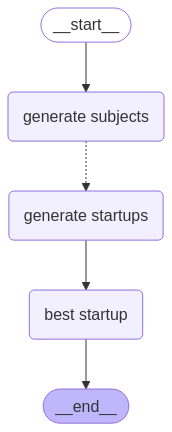

In [ ]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate subjects", generate_topics)
graph.add_node("generate startups", generate_startup)
graph.add_node("best startup", best_startup)
graph.add_edge(START, "generate subjects")

# Jeżeli wygenerowane tematy będą miały sens, to generuj startupy, jak nie to ponów
graph.add_conditional_edges("generate subjects", continue_to_startups, ["generate startups"])
graph.add_edge("generate startups", "best startup")
graph.add_edge("best startup", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [10]:
# Call the graph: here we call it to generate a list of startups
for s in app.stream({"topic": "sustainability"}):
    print(s)

{'generate subjects': {'subjects': ['Sustainable Resource Management', 'Renewable Energy Development', 'Green Infrastructure and Urban Planning', 'Corporate Social Responsibility', 'Consumer Behavior and Eco-Friendly Products']}}
{'generate startups': {'startups': ['Launch “ECO Efficiency,” a data-driven platform that helps businesses monitor, track, and optimize their usage of resources like water, energy, and raw materials. The startup would combine IoT sensors with machine learning to measure key performance metrics in real time, automatically generating actionable insights—such as identifying inefficiencies, offering best-practice recommendations, and calculating resource-saving targets. Revenue could come from a subscription model for continuous analytics, consulting services, and licensing of the technology to different industries. By illustrating clear savings in time, money, and environmental impact, ECO Efficiency would empower companies to evolve toward more sustainable produ